In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/deeplearning-alterationzones

/content/drive/MyDrive/deeplearning-alterationzones


In [4]:
!ls 

 Alteration_Zones.ipynb   main.py	  output_prediction.py	 references
 Image_preprocessing.py  'Mapped Files'   README.md


In [5]:
!pip install pyrsgis
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
#from Image_preprocessing import multiclass_preprocess
import time
import random
import numpy as np
import tensorflow as tf
from numpy import asarray
from numpy import save
from keras import backend as K
from numpy import load
import pandas as pd
import seaborn as sns
from pyrsgis import raster
from pyrsgis.ml import array_to_chips   #imagechipsfromarray doesnt work anymore.
from math import floor
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc



In [9]:
# Defining file names

feature_file = 'BrokenHill_ASTER.tif'
positiveLabel_file = 'BrokenHill_ASTER_CombinedTraining_PCA.tif'

##Multiclass_preprocess class of Image_preprocessing for preprocessing the datasets.

In [ ]:
# class multiclass_preprocess:

#     def __init__(self, feature_file, positivelabel_file):
#         self.feature_file =  feature_file
#         self.positivelabel_file = positivelabel_file

#     def read_and_normalise_input(self):
#         # Reading and normalizing input data
#         dsFeatures, arrFeatures = raster.read(self.feature_file, bands='all')
#         # arrFeatures = arrFeatures.astype(float)
#         arrFeatures = np.float16(arrFeatures)

#         for i in range(arrFeatures.shape[0]):
#             bandMin = arrFeatures[i][:][:].min()
#             bandMax = arrFeatures[i][:][:].max()
#             bandRange = bandMax-bandMin
#             for j in range(arrFeatures.shape[1]):
#                 for k in range(arrFeatures.shape[2]):
#                     arrFeatures[i][j][k] = (arrFeatures[i][j][k]-bandMin)/bandRange

#         # Creating chips using pyrsgis
#         features = array_to_chips(arrFeatures, x_size=7, y_size=7)

#         return features

#     def read_and_normalise_labels(self):
#         # Reading and reshaping the label file
#         dsPositive, positiveLabels = raster.read(self.positivelabel_file)

#         # Generating random samples
#         nonZero_count = 0

#         for i in range(positiveLabels.shape[0]):
#             for j in range(positiveLabels.shape[1]):
#                 if positiveLabels[i,j] != 0:
#                     nonZero_count += 1

#         k = 0
#         index = np.zeros(((positiveLabels.shape[0]*positiveLabels.shape[1])-nonZero_count,2))

#         #Appending all the coordinates of points with zero labels in the index array
#         for i in range(positiveLabels.shape[0]):
#             for j in range(positiveLabels.shape[1]):
#                 if positiveLabels[i,j] == 0:
#                     index[k,0] = i
#                     index[k,1] = j
#                     k += 1

#         #Random Index of nonZero_count/2 coordinates from index
#         randomIndex = random.sample(range(index.shape[0]), floor(nonZero_count/2))
#         negativeLabels = np.zeros(positiveLabels.shape)

#         index = index.astype(int)

#         for i in range(len(randomIndex)):
#             negativeLabels[index[randomIndex[i],0],index[randomIndex[i],1]] = np.max(positiveLabels)+1

#         del index


#         positiveLabels = positiveLabels.flatten()
#         negativeLabels = negativeLabels.flatten()

#         features = self.read_and_normalise_input()
#         # Separating and balancing the classes
#         positiveFeatures = features[positiveLabels!=0]
#         positiveLabels = positiveLabels[positiveLabels!=0]

#         negativeFeatures = features[negativeLabels==np.max(positiveLabels)+1]
#         negativeLabels = negativeLabels[negativeLabels==np.max(positiveLabels)+1]

#         # Combining the balanced features
#         features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
#         labels = np.concatenate((positiveLabels, negativeLabels), axis=0)

#         del positiveFeatures
#         del negativeFeatures
#         del positiveLabels
#         del negativeLabels

#         return features, labels

#     # Defining the function to split features and labels
#     def train_test_split(self, trainProp=0.75):
#         features, labels = self.read_and_normalise_labels()
#         dataSize = features.shape[0]
#         sliceIndex = int(dataSize*trainProp)
#         randIndex = np.arange(dataSize)
#         random.shuffle(randIndex)
#         train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
#         test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
#         train_y = labels[randIndex[:sliceIndex]]
#         test_y = labels[randIndex[sliceIndex:]]

#         return(train_x, train_y, test_x, test_y)



In [ ]:
# ############# All the preprocessing of the image has been done in the image_preprocessing.py file ##############
# multiclass_preprocess_instance = multiclass_preprocess(feature_file, positiveLabel_file)
# train_x, train_y, test_x, test_y = multiclass_preprocess_instance.train_test_split()

# # save numpy array as csv file

# save('train_x.npy', train_x)
# save('train_y.npy', train_y)
# save('test_x.npy', test_x)
# save('test_y.npy', test_y)

## Loading the already preprocessed data

In [10]:
from numpy import load

NAME = "ASTER_DATA"     #Name of the folder in which the already preprocessed files exist.

train_x = load('Data/{}/train_x.npy'.format(NAME))
train_y = load('Data/{}/train_y.npy'.format(NAME))
validation_x = load('Data/{}/validation_x.npy'.format(NAME))
validation_y = load('Data/{}/validation_y.npy'.format(NAME))
test_x = load('Data/{}/test_x.npy'.format(NAME))
test_y = load('Data/{}/test_y.npy'.format(NAME))

In [15]:
import pandas as pd
results_df = pd.read_csv("results_df.csv")

## Experimentation with Oversampling and Undersampling Techniques due to imbalanced datasets.

In [ ]:
# reshaped_train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1]*train_x.shape[2]*train_x.shape[3]))
# reshaped_test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1]*test_x.shape[2]*test_x.shape[3]))

# # define undersample strategy
# undersample = RandomUnderSampler()
# train_x_undersampled, train_y_undersampled = undersample.fit_resample(reshaped_train_x, train_y)
# train_x_undersampled = np.reshape(train_x_undersampled, (train_x_undersampled.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3]))

# test_x_undersampled, test_y_undersampled = undersample.fit_resample(reshaped_test_x, test_y)
# test_x_undersampled = np.reshape(test_x_undersampled, (test_x_undersampled.shape[0], test_x.shape[1], test_x.shape[2], test_x.shape[3]))

# #define oversample strategy
# oversample = RandomOverSampler()
# train_x_oversampled, train_y_oversampled = oversample.fit_resample(reshaped_train_x, train_y)
# train_x_oversampled = np.reshape(train_x_oversampled, (train_x_oversampled.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3]))

# test_x_oversampled, test_y_oversampled = oversample.fit_resample(reshaped_test_x, test_y)
# test_x_oversampled = np.reshape(test_x_oversampled, (test_x_oversampled.shape[0], test_x.shape[1], test_x.shape[2], test_x.shape[3]))

In [12]:
print(sum(train_y == 2.))
print(sum(train_y == 1.))
print(sum(train_y == 0.))
# print("Undersampled Data")
# print(sum(train_y_undersampled == 2.))
# print(sum(train_y_undersampled == 1.))
# print(sum(train_y_undersampled == 0.))
# print("Oversampled Data")
# print(sum(train_y_oversampled == 2.))
# print(sum(train_y_oversampled == 1.))
# print(sum(train_y_oversampled == 0.))


171032
64580
117460


In [ ]:
train_x.shape[1]* train_x.shape[2]* train_x.shape[3]

441

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [13]:
def plot_metric(history, metric):    #For plotting any graph relating to any model
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [17]:
#Function to collect the results on the test data
def results(model, test_x, test_y):
  y_pred = model.predict(test_x, batch_size=64, verbose=1)
  y_pred_final = np.empty_like(test_y)
  j = 0
  for i in y_pred:
    max_index = np.where(i == max(i))[0] 
    y_pred_final[j] = float(max_index) 
    j = j + 1


  Accuracy = accuracy_score(test_y, y_pred_final)
  precision = precision_score(test_y, y_pred_final, average = 'macro')
  recall = recall_score(test_y, y_pred_final, average = 'macro')
  F1_score = f1_score(test_y, y_pred_final, average = 'macro')

  return y_pred, Accuracy, precision, recall, F1_score

In [35]:
def plot_AUC_ROC(model, test_x, test_y, n_classes, figsize=(6.4, 4.8)):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  y_pred = model.predict(test_x, batch_size=64, verbose=1)
  y_test_dummies = pd.get_dummies(test_y, drop_first=False).values
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

      # roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic example')
  for i in range(n_classes):
      ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

## CNN model with "rmsprop" optimizer

In [18]:
############## ORiginal Model Code ###################
Model_name = "CNN_RMSPROP"

model = Sequential()

model.add(Conv2D(32, kernel_size=3, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size= 3, padding='valid', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

print(model.summary())
#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

log_folder = "logs/{}".format(NAME)

callbacks = [TensorBoard(log_dir=log_folder,
                histogram_freq=1,
                  write_graph=True,
                  write_images=True,
                  update_freq='epoch',
                  profile_batch=2,
                  embeddings_freq=1)]

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(train_x, train_y, epochs = 10, validation_data = (validation_x, validation_y))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 32)          2624      
                                                                 
 dense (Dense)               (None, 5, 5, 64)          2112      
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 48)          27696     
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 48)          0         
                                                                 
 flatten (Flatten)           (None, 432)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                2

In [19]:
y_pred, Accuracy, precision, recall, F1_score = results(model, test_x)
results_df = results_df.append({'Model' : '{}_{}_MODEL'.format(NAME, Model_name), 'Accuracy' : Accuracy, 'F1-Score': F1_score, 'Precision': precision, 'Recall': recall }, ignore_index = True)

model.save('models/{}_{}_MODEL'.format(NAME, Model_name))
results_df.to_csv("results_df.csv")

2299/2299 [==============================] - 5s 2ms/step
INFO:tensorflow:Assets written to: models/ASTER_DATA_CNN_RMSPROP_MODEL/assets


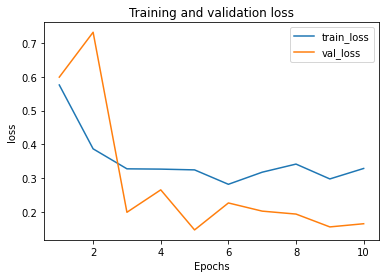

In [20]:
plot_metric(history, "loss")

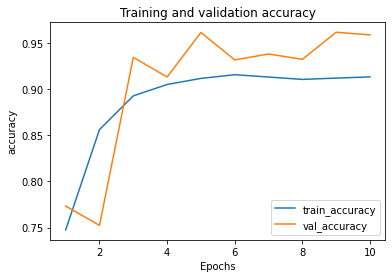

In [21]:
plot_metric(history, "accuracy")

2299/2299 [==============================] - 5s 2ms/step


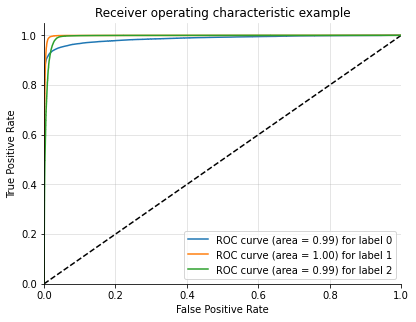

In [36]:
plot_AUC_ROC(model, test_x, test_y, 3)

## CNN model with "Adam" optimizer

In [38]:
############## ORiginal Model Code ###################
Model_name = "CNN_ADAM"

model = Sequential()

model.add(Conv2D(32, kernel_size=3, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size= 3, padding='valid', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

print(model.summary())
#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

log_folder = "logs/{}".format(NAME)

callbacks = [TensorBoard(log_dir=log_folder,
                histogram_freq=1,
                  write_graph=True,
                  write_images=True,
                  update_freq='epoch',
                  profile_batch=2,
                  embeddings_freq=1)]

model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(train_x, train_y, epochs = 10, validation_data = (validation_x, validation_y))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 5, 5, 32)          2624      
                                                                 
 dense_6 (Dense)             (None, 5, 5, 64)          2112      
                                                                 
 dropout_6 (Dropout)         (None, 5, 5, 64)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 48)          27696     
                                                                 
 dropout_7 (Dropout)         (None, 3, 3, 48)          0         
                                                                 
 flatten_2 (Flatten)         (None, 432)               0         
                                                                 
 dense_7 (Dense)             (None, 64)               

In [39]:
y_pred, Accuracy, precision, recall, F1_score = results(model, test_x)
results_df = results_df.append({'Model' : '{}_{}_MODEL'.format(NAME, Model_name), 'Accuracy' : Accuracy, 'F1-Score': F1_score, 'Precision': precision, 'Recall': recall }, ignore_index = True)

model.save('models/{}_{}_MODEL'.format(NAME, Model_name))
results_df.to_csv("results_df.csv")

2299/2299 [==============================] - 5s 2ms/step
INFO:tensorflow:Assets written to: models/ASTER_DATA_CNN_ADAM_MODEL/assets


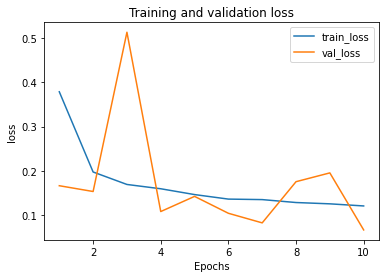

In [40]:
plot_metric(history, "loss")

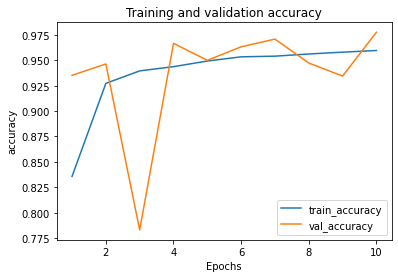

In [41]:
plot_metric(history, "accuracy")

2299/2299 [==============================] - 5s 2ms/step


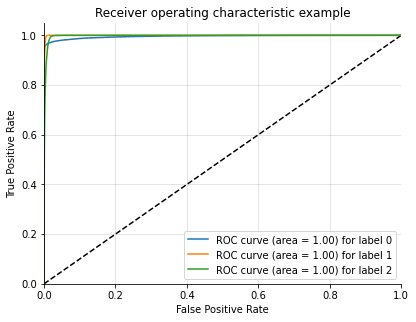

In [42]:
plot_AUC_ROC(model, test_x, test_y, 3)

## CNN model with "SGD" optimizer

In [43]:
############## ORiginal Model Code ###################
Model_name = "CNN_SGD"

model = Sequential()

model.add(Conv2D(32, kernel_size=3, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size= 3, padding='valid', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

print(model.summary())
#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

log_folder = "logs/{}".format(NAME)

callbacks = [TensorBoard(log_dir=log_folder,
                histogram_freq=1,
                  write_graph=True,
                  write_images=True,
                  update_freq='epoch',
                  profile_batch=2,
                  embeddings_freq=1)]

model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
history = model.fit(train_x, train_y, epochs = 10, validation_data = (validation_x, validation_y))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 5, 5, 32)          2624      
                                                                 
 dense_9 (Dense)             (None, 5, 5, 64)          2112      
                                                                 
 dropout_9 (Dropout)         (None, 5, 5, 64)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 48)          27696     
                                                                 
 dropout_10 (Dropout)        (None, 3, 3, 48)          0         
                                                                 
 flatten_3 (Flatten)         (None, 432)               0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [44]:
y_pred, Accuracy, precision, recall, F1_score = results(model, test_x)
results_df = results_df.append({'Model' : '{}_{}_MODEL'.format(NAME, Model_name), 'Accuracy' : Accuracy, 'F1-Score': F1_score, 'Precision': precision, 'Recall': recall }, ignore_index = True)

model.save('models/{}_{}_MODEL'.format(NAME, Model_name))
results_df.to_csv("results_df.csv")

2299/2299 [==============================] - 5s 2ms/step
INFO:tensorflow:Assets written to: models/ASTER_DATA_CNN_SGD_MODEL/assets


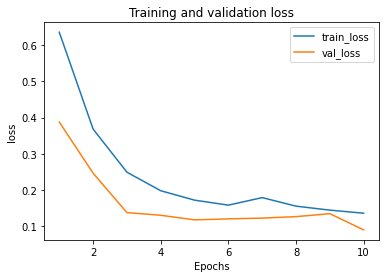

In [45]:
plot_metric(history, "loss")

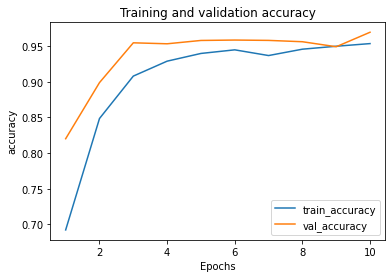

In [46]:
plot_metric(history, "accuracy")

2299/2299 [==============================] - 5s 2ms/step


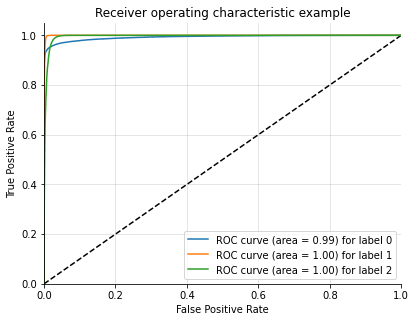

In [47]:
plot_AUC_ROC(model, test_x, test_y, 3)

## MLP Model

In [67]:
reshaped_train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1]*train_x.shape[2]*train_x.shape[3]))
reshaped_validation_x = np.reshape(validation_x, (validation_x.shape[0], validation_x.shape[1]*validation_x.shape[2]*validation_x.shape[3]))
reshaped_test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1]*test_x.shape[2]*test_x.shape[3]))
reshaped_train_x.shape

(353072, 441)

In [74]:
############## ORiginal Model Code ###################
Model_name = "MLP"

model = Sequential()


model.add(Dense(64, activation='relu', input_shape=(train_x.shape[1]* train_x.shape[2]* train_x.shape[3],)))

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(3, activation='softmax'))

print(model.summary())
#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

log_folder = "logs/{}".format(NAME)

callbacks = [TensorBoard(log_dir=log_folder,
                histogram_freq=1,
                  write_graph=True,
                  write_images=True,
                  update_freq='epoch',
                  profile_batch=2,
                  embeddings_freq=1)]



model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(reshaped_train_x, train_y, epochs = 10, validation_data = (reshaped_validation_x, validation_y))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 64)                28288     
                                                                 
 dense_29 (Dense)            (None, 128)               8320      
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dense_31 (Dense)            (None, 3)                 195       
                                                                 
Total params: 45,059
Trainable params: 45,059
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
11034/11034 [==============================] - 36s 3ms/step - loss: 0.3895 - accuracy: 0.8283 - val_loss: 0.4640 - val_accuracy: 0.7792
Epoch 2/10
11034/11034 [======

In [75]:
y_pred, Accuracy, precision, recall, F1_score = results(model, reshaped_test_x)
results_df = results_df.append({'Model' : '{}_{}_MODEL'.format(NAME, Model_name), 'Accuracy' : Accuracy, 'F1-Score': F1_score, 'Precision': precision, 'Recall': recall }, ignore_index = True)

model.save('models/{}_{}_MODEL'.format(NAME, Model_name))
results_df.to_csv("results_df.csv")

2299/2299 [==============================] - 3s 1ms/step
INFO:tensorflow:Assets written to: models/ASTER_DATA_MLP_MODEL/assets


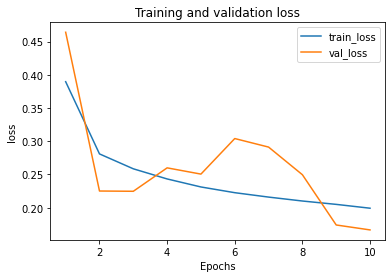

In [76]:
plot_metric(history, "loss")

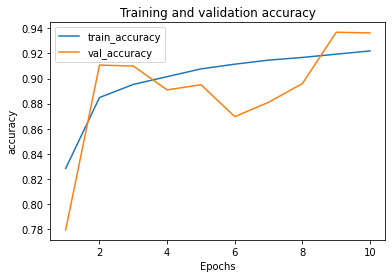

In [77]:
plot_metric(history, "accuracy")

2299/2299 [==============================] - 3s 2ms/step


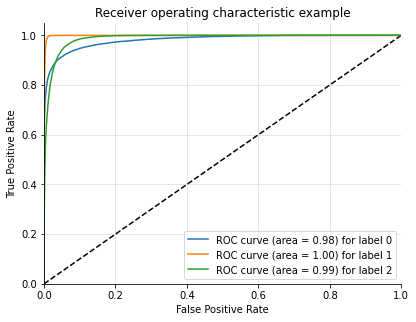

In [78]:
plot_AUC_ROC(model, reshaped_test_x, test_y, 3)